# SNN Conversion
We now want to convert our trained ANN network into an SNN network.

For this we can load our pretrained ANN and convert it using SINABS.

In [1]:
import torch
import torch.nn as nn
import sinabs
import sinabs.layers as sl
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt# Calculate MSE for all result dfs
from sklearn.metrics import mean_squared_error
# Calculate R2 for all result dfs
from sklearn.metrics import r2_score

In [2]:
# Model definition

ann = nn.Sequential(
    nn.Linear(3, 256),  # Input layer: 3 features (mu, sigma, x)
    nn.ReLU(),
    #nn.Dropout(0.2),
    nn.Linear(256, 256),  # first hidden layer
    nn.ReLU(),
    #nn.Dropout(0.2),
    nn.Linear(256, 256),  # second hidden layer
    nn.ReLU(),
    #nn.Dropout(0.2),
    nn.Linear(256, 1)    # Output layer: single value for f(x; mu, sigma)
)

In [3]:
ann.load_state_dict(torch.load("./results/2x256hidden_SGD_train_data_final/ann_epoch_499.pth"))

C:\Users\Lutz\AppData\Local\Temp\ipykernel_20080\3253550333.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ann.load_state_dict(torch.load("./results/2x256hidden_SGD_tra

<All keys matched successfully>

In [4]:
# Convert to SNN
num_time_steps_per_sample = 100

snn_lin_out = sinabs.from_model(ann, input_shape=(3,), add_spiking_output=False, synops=False, num_timesteps=num_time_steps_per_sample, spike_layer_class=sinabs.layers.IAF)

In [5]:
snn_lin_out

Network(
  (spiking_model): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): IAF(spike_threshold=Parameter containing:
    tensor(1.), min_v_mem=Parameter containing:
    tensor(-1.))
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): IAF(spike_threshold=Parameter containing:
    tensor(1.), min_v_mem=Parameter containing:
    tensor(-1.))
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): IAF(spike_threshold=Parameter containing:
    tensor(1.), min_v_mem=Parameter containing:
    tensor(-1.))
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
  (analog_model): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)

We can see that the transformation replaced all ReLU() Activation functions with an IAFSqueeze Layer and added a spike_output layer of the same name.

We now need to test how the results compare with this transformed model.

In [7]:
# Get Test Dataset

# Load test dataset
test_df = pd.read_csv('./data_generation/test_data_min_max_input_half_lin_half_normal.csv')

In [8]:
class DataFrameDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, is_spiking=False, timesteps=100):
        self.timesteps = timesteps
        self.is_spiking = is_spiking
        self.inputval = torch.Tensor(dataframe["Series1"])
        self.mean = torch.Tensor(dataframe["Series2"])
        self.std = torch.Tensor(dataframe["Series3"])
        self.features = torch.stack([self.inputval, self.mean, self.std], dim=1)
        self.labels = torch.Tensor(dataframe["Label"])

    def __len__(self):
        return len(self.inputval)

    def __getitem__(self, idx):
        feature = self.features[idx]        
        labels = self.labels[idx]
        
        # Repeat for timesteps
        if self.is_spiking:
            feature = feature.repeat(self.timesteps, 1)
            labels = labels.repeat(self.timesteps, 1)
        
        return feature, labels
    
test_dataset = DataFrameDataset(test_df, is_spiking=True, timesteps=num_time_steps_per_sample)

In [9]:
feature, label = test_dataset[0]
feature.shape

torch.Size([100, 3])

In [10]:
label.shape

torch.Size([100, 1])

In [11]:
BATCH_SIZE = 1024

dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Try to run a batch
def eval_loop(dataloader, model, mode="mean", apply_from=0, is_norse=False):
    results = []

    for data, target in tqdm(dataloader):
        data, target = data.to("cpu"), target.to("cpu")

        with torch.no_grad():
            output = model(data)
            if is_norse:
                print(f"Data shape: {data.shape}")
                output = output[0]
                print(output.shape)
            for i in range(BATCH_SIZE):
                try:
                    if not is_norse:
                        if mode == "mean":
                            results.append((target[0, i, :].item(), output[apply_from:, i, :].mean().item()))
                        elif mode == "count":
                            results.append((target[0, i, :].item(), (output[apply_from:, i, :] > 0).sum().item()))
                        elif mode == "last":
                            results.append((target[0, i, :].item(), output[-1, i, :].item()))
                    else:
                        if mode == "mean":
                            results.append((target[0, i, :].item(), output[apply_from:, i, :].mean().item(), output))
                        elif mode == "count":
                            results.append((target[0, i, :].item(), (output[apply_from:, i, :] > 0).sum().item(), output))
                except Exception:
                    break
                
    return results

results = eval_loop(dataloader, snn_lin_out)
results_last = eval_loop(dataloader, snn_lin_out, mode="last")

  0%|          | 0/196 [00:00<?, ?it/s]

Data shape: torch.Size([1024, 100, 3])
Target shape: torch.Size([1024, 100, 1])
Data shape: torch.Size([1024, 100, 3])
Target shape: torch.Size([1024, 100, 1])
Data shape: torch.Size([1024, 100, 3])
Target shape: torch.Size([1024, 100, 1])
Data shape: torch.Size([1024, 100, 3])
Target shape: torch.Size([1024, 100, 1])
Data shape: torch.Size([1024, 100, 3])
Target shape: torch.Size([1024, 100, 1])
Data shape: torch.Size([1024, 100, 3])
Target shape: torch.Size([1024, 100, 1])
Data shape: torch.Size([1024, 100, 3])
Target shape: torch.Size([1024, 100, 1])


: 

In [13]:
# Transform  results to dataframe
results_df = pd.DataFrame(results, columns=["target", "output"])
results_last_df = pd.DataFrame(results_last, columns=["target", "output"])

# Add absolute diff
results_df["abs_diff"] = abs(results_df["target"] - results_df["output"])
results_last_df["abs_diff"] = abs(results_last_df["target"] - results_last_df["output"])

results_df.head()

,target,output,abs_diff
0,0.036083,0.040635,0.004552
1,0.036083,-0.005382,0.041465
2,0.036083,0.029083,0.007000
3,0.036083,0.062183,0.026100
4,0.036083,0.099207,0.063124


In [14]:
results_df.describe()

,target,output,abs_diff
count,1.960000e+04,19600.000000,19600.000000
mean,1.159301e-01,0.099520,0.126735
std,3.098120e-01,0.023032,0.284702
min,0.000000e+00,-0.005382,0.000010
25%,4.936972e-10,0.092962,0.040709
50%,4.206871e-02,0.104172,0.087879
75%,1.049882e-01,0.113673,0.111287
max,3.076536e+00,0.163889,3.049640


In [15]:
results_last_df.describe()

,target,output,abs_diff
count,1.960000e+04,19600.000000,19600.000000
mean,1.159301e-01,0.129647,0.268553
std,3.098120e-01,0.477057,0.512420
min,0.000000e+00,-0.696449,0.000005
25%,4.936972e-10,-0.054934,0.061260
50%,4.206871e-02,0.040562,0.137297
75%,1.049882e-01,0.171036,0.273125
max,3.076536e+00,8.844668,8.844586


In [16]:
print(f"MSE: {mean_squared_error(results_df['target'], results_df['output'])}")
print(f"R2: {r2_score(results_df['target'], results_df['output'])}")
print(f"MSE: {mean_squared_error(results_last_df['target'], results_last_df['output'])}")
print(f"R2: {r2_score(results_last_df['target'], results_last_df['output'])}")


MSE: 0.09711276405775537
R2: -0.011817366364017534
MSE: 0.3346819486467708
R2: -2.487049422751032


(array([3.524e+03, 3.670e+03, 3.203e+03, 6.114e+03, 9.240e+02, 2.120e+02,
        2.610e+02, 3.230e+02, 2.120e+02, 4.400e+01, 1.740e+02, 1.900e+01,
        9.100e+01, 1.000e+02, 2.700e+01, 1.650e+02, 9.700e+01, 2.400e+01,
        1.300e+01, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 9.000e+00, 7.600e+01, 9.000e+00, 6.000e+00, 0.000e+00,
        0.000e+00, 8.000e+00, 7.700e+01, 5.000e+00, 1.000e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 5.900e+01, 3.000e+01,
        8.000e+00, 3.000e+00, 0.000e+0

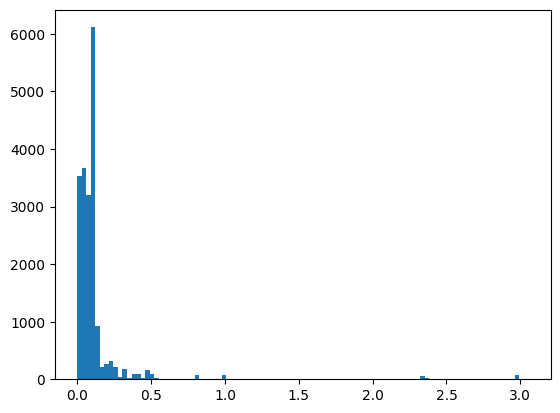

In [19]:
# Plot abs_diff
plt.hist(results_df["abs_diff"], bins=100)

             target       output     abs_diff
count  7.523000e+03  7523.000000  7523.000000
mean   2.001641e-01     0.107690     0.245823
std    4.834648e-01     0.018489     0.432119
min    0.000000e+00     0.017214     0.100001
25%    1.216856e-17     0.103505     0.108046
50%    1.755628e-06     0.109802     0.116942
75%    2.979042e-01     0.117047     0.191846
max    3.076536e+00     0.163436     3.054186


(array([5085.,   24.,    0.,    0.,   38.,   63.,  113.,    0.,  100.,
         400.,  300.,  300.,    0.,  100.,  100.,    0.,  200.,    0.,
         100.,  100.,  100.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,  100.,    0.,    0.,    0.,    0.,    0.,  100.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,  100.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         100.]),
 array([0.        , 0.03076536, 0.06153071, 0.09229607, 0.12306143,
        0.15382679, 0.18459214, 0.2153575 , 0.24612286, 0.27688821,
        0.30765357, 0.33841893, 0.36918428, 0.39994964, 0.430715  

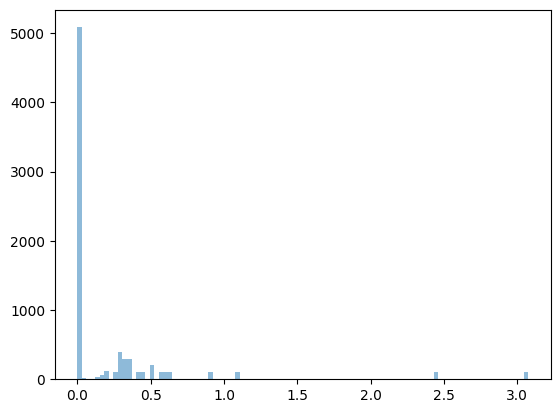

In [20]:
# Get the ones where abs_diff is greater than 0.1
print(results_df[results_df["abs_diff"] > 0.1].describe())

# Plot the targets and outputs for this subset
plt.hist(results_df[results_df["abs_diff"] > 0.1]["target"], bins=100, alpha=0.5, label="target")

             target        output      abs_diff
count  12077.000000  12077.000000  12077.000000
mean       0.063459      0.094346      0.052483
std        0.054881      0.024041      0.029975
min        0.000000      0.014935      0.000011
25%        0.003674      0.087361      0.027072
50%        0.062488      0.098457      0.050173
75%        0.097913      0.109879      0.081289
max        0.201552      0.157153      0.099997


(array([2954.,  108.,   53.,   32.,   75.,   70.,   66.,    0.,    0.,
         283.,   98.,   88.,   99.,   94.,   95.,  187.,  100.,  190.,
           0.,   99.,    0.,  100.,  100.,  200.,  100.,  100.,    0.,
         200.,  100.,  300.,  100.,  400.,  100.,  400.,  200.,  300.,
         400.,  100.,  100.,    0.,  200.,    0.,    0.,    0.,  100.,
         100.,  400.,  100.,  200.,  300.,    0.,  200.,    0.,  100.,
         100.,  200.,  200.,    0.,  100.,    0.,    0.,    0.,    0.,
           0.,  197.,  197.,    0.,   97.,    0.,    0.,    0.,    0.,
           0.,   93.,  278.,    0.,    0.,    0.,    0.,   92.,   88.,
          91.,    0.,   89.,    0.,   89.,    0.,   88.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,   81.,    0.,    0.,  141.,
         165.]),
 array([0.        , 0.00201552, 0.00403104, 0.00604656, 0.00806208,
        0.0100776 , 0.01209313, 0.01410865, 0.01612417, 0.01813969,
        0.02015521, 0.02217073, 0.02418625, 0.02620177, 0.02821729

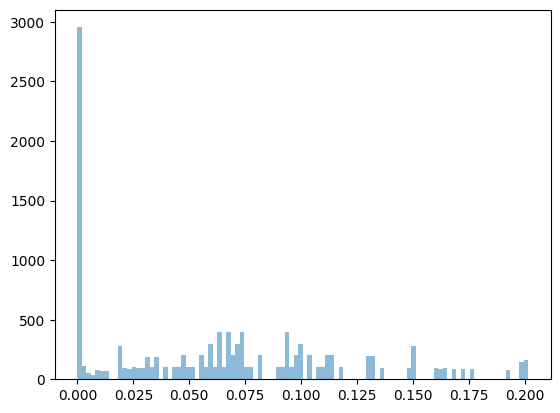

In [21]:
# Plot hist for the ones with error under 0.1
print(results_df[results_df["abs_diff"] < 0.1].describe())
plt.hist(results_df[results_df["abs_diff"] < 0.1]["target"], bins=100, alpha=0.5, label="target")

Text(0.5, 0.98, 'Distribution of target values for different error levels')

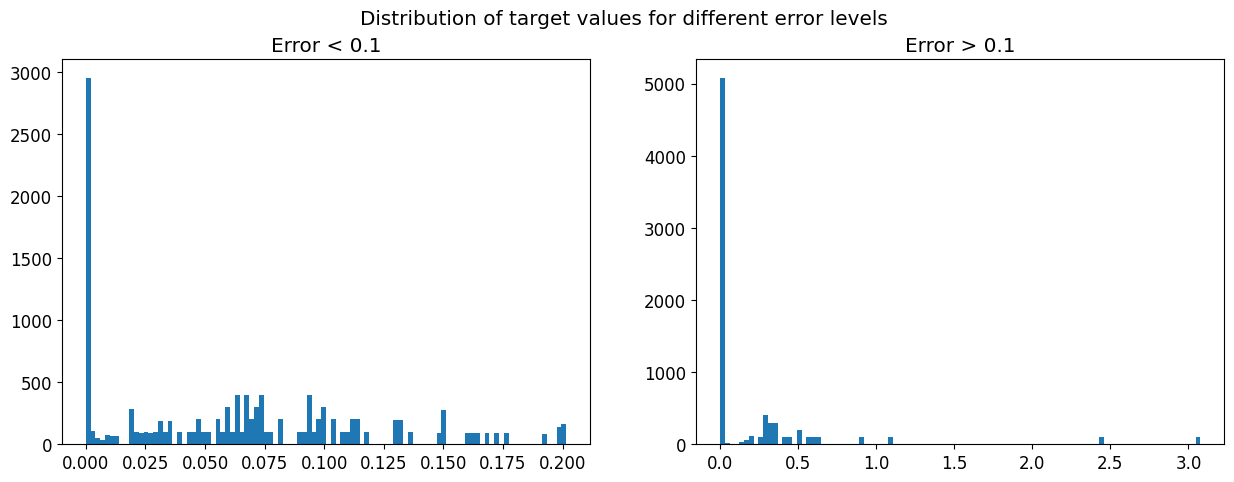

In [22]:
# Plot hist for the ones with error under 0.1 and ones with error higher than 0.1 next to each other in two subplots
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(results_df[results_df["abs_diff"] < 0.1]["target"], bins=100, alpha=1, label="target")
axs[1].hist(results_df[results_df["abs_diff"] > 0.1]["target"], bins=100, alpha=1, label="target")
axs[0].set_title("Error < 0.1")
axs[1].set_title("Error > 0.1")

# Figure title
fig.suptitle("Distribution of target values for different error levels")
# Font size



In [23]:
results2 = eval_loop(dataloader, snn_lin_out, mode="mean", apply_from=int(0.1*num_time_steps_per_sample))
results3 = eval_loop(dataloader, snn_lin_out, mode="mean", apply_from=int(0.2*num_time_steps_per_sample))
results4 = eval_loop(dataloader, snn_lin_out, mode="mean", apply_from=int(0.3*num_time_steps_per_sample))
results5 = eval_loop(dataloader, snn_lin_out, mode="mean", apply_from=int(0.4*num_time_steps_per_sample))
results6 = eval_loop(dataloader, snn_lin_out, mode="mean", apply_from=int(0.5*num_time_steps_per_sample))

results_df2 = pd.DataFrame(results2, columns=["target", "output"])
results_df3 = pd.DataFrame(results3, columns=["target", "output"])
results_df4 = pd.DataFrame(results4, columns=["target", "output"])
results_df5 = pd.DataFrame(results5, columns=["target", "output"])
results_df6 = pd.DataFrame(results6, columns=["target", "output"])

results_df2["abs_diff"] = abs(results_df2["target"] - results_df2["output"])
results_df3["abs_diff"] = abs(results_df3["target"] - results_df3["output"])
results_df4["abs_diff"] = abs(results_df4["target"] - results_df4["output"])
results_df5["abs_diff"] = abs(results_df5["target"] - results_df5["output"])
results_df6["abs_diff"] = abs(results_df6["target"] - results_df6["output"])

print(f"Max error for 0.1: {results_df2['abs_diff'].max()}; mean error: {results_df2['abs_diff'].mean()}")
print(f"Max error for 0.2: {results_df3['abs_diff'].max()}; mean error: {results_df3['abs_diff'].mean()}")
print(f"Max error for 0.3: {results_df4['abs_diff'].max()}; mean error: {results_df4['abs_diff'].mean()}")
print(f"Max error for 0.4: {results_df5['abs_diff'].max()}; mean error: {results_df5['abs_diff'].mean()}")
print(f"Max error for 0.5: {results_df6['abs_diff'].max()}; mean error: {results_df6['abs_diff'].mean()}")

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Max error for 0.1: 3.0512797627598047; mean error: 0.12690337800753004
Max error for 0.2: 3.0516255497932434; mean error: 0.12697875421379776
Max error for 0.3: 3.0527072213590145; mean error: 0.12693552637548344
Max error for 0.4: 3.0530678499490023; mean error: 0.12687753013358494
Max error for 0.5: 3.050852980464697; mean error: 0.1269090328850189


In [24]:
print(f"MSE for 0.0: {mean_squared_error(results_df['target'], results_df['output'])}")
print(f"MSE for 0.1: {mean_squared_error(results_df2['target'], results_df2['output'])}")
print(f"MSE for 0.2: {mean_squared_error(results_df3['target'], results_df3['output'])}")
print(f"MSE for 0.3: {mean_squared_error(results_df4['target'], results_df4['output'])}")
print(f"MSE for 0.4: {mean_squared_error(results_df5['target'], results_df5['output'])}")
print(f"MSE for 0.5: {mean_squared_error(results_df6['target'], results_df6['output'])}")


print(f"R2 for 0.0: {r2_score(results_df['target'], results_df['output'])}")
print(f"R2 for 0.1: {r2_score(results_df2['target'], results_df2['output'])}")
print(f"R2 for 0.2: {r2_score(results_df3['target'], results_df3['output'])}")
print(f"R2 for 0.3: {r2_score(results_df4['target'], results_df4['output'])}")
print(f"R2 for 0.4: {r2_score(results_df5['target'], results_df5['output'])}")
print(f"R2 for 0.5: {r2_score(results_df6['target'], results_df6['output'])}")

MSE for 0.0: 0.09710612247598259
MSE for 0.1: 0.09735572465801272
MSE for 0.2: 0.0974256127121065
MSE for 0.3: 0.0973983557364567
MSE for 0.4: 0.09737434970137841
MSE for 0.5: 0.09740971497050198
R2 for 0.0: -0.011748167759251027
R2 for 0.1: -0.014348771551253359
R2 for 0.2: -0.01507693481094008
R2 for 0.3: -0.014792944528255525
R2 for 0.4: -0.014542825777899449
R2 for 0.5: -0.014911296326673984


In [28]:
# Export to NIR
from sinabs import to_nir
from  sinabs.activation.reset_mechanism import MembraneSubtract

nir_model = to_nir(snn_lin_out.spiking_model, test_dataset[0][0], "snn_lin_out")

import norse.torch as norse

norse_model = norse.from_nir(nir_model, reset_method=norse.reset_subtract)

norse_model

TypeError: ones() received an invalid combination of arguments - got (), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)


In [21]:
for name, layer in norse_model.named_children():
    if isinstance(layer, torch.nn.Linear):
        print(name)
        snn_lin_out_weights = snn_lin_out.spiking_model[int(name)].state_dict()['weight']
        snn_lin_out_bias = snn_lin_out.spiking_model[int(name)].state_dict()['bias']
        
        assert torch.allclose(layer.state_dict()['weight'], snn_lin_out_weights), f"Layer {name} weights are not equal"
        assert torch.allclose(layer.state_dict()['bias'], snn_lin_out_bias), f"Layer {name} biases are not equal"

0
2
4
6


In [22]:
batch_1_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

results_norse = eval_loop(dataloader, norse_model, is_norse=True)

  0%|          | 0/196 [00:00<?, ?it/s]

Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape

In [23]:
results_df_norse = pd.DataFrame(results_norse, columns=["target", "output", "model_output"])
results_df_norse["abs_diff"] = abs(results_df_norse["target"] - results_df_norse["output"])
results_df_norse.head()

,target,output,model_output,abs_diff
0,0.036083,0.045391,"[[[tensor(0.0454)], [tensor(0.0454)], [tensor(...",0.009308
1,0.061312,0.045391,"[[[tensor(0.0454)], [tensor(0.0454)], [tensor(...",0.015921
2,0.023691,0.045391,"[[[tensor(0.0454)], [tensor(0.0454)], [tensor(...",0.021700
3,0.622410,0.045391,"[[[tensor(0.0454)], [tensor(0.0454)], [tensor(...",0.577019
4,0.116947,0.045391,"[[[tensor(0.0454)], [tensor(0.0454)], [tensor(...",0.071556


In [24]:
# Metrics
print(f"Max error for norse: {results_df_norse['abs_diff'].max()}; mean error: {results_df_norse['abs_diff'].mean()}")
print(f"MSE for norse: {mean_squared_error(results_df_norse['target'], results_df_norse['output'])}")
print(f"R2 for norse: {r2_score(results_df_norse['target'], results_df_norse['output'])}")

Max error for norse: 3.9440310560166836; mean error: 0.10447808228115227
MSE for norse: 0.09407019632694077
R2 for norse: -0.044375330335329366


# First results
We can see that on average our results are pretty okay with the the mean absolute difference being around 0.01, with some having larger error, specifically those that would have a higher target number anyways reaching an error of up to 0.7.

We can also see that if we give the SNN some time to reach around the target and only take the average of, for example, the second half of the timesteps our results improve again by a good amount.

Most records with small targets also have small error, showing some sort of correlation here.

We want to now see how the outputs look if we were to count spike outputs for each input

In [25]:
from sinabs.activation import MembraneReset, SingleSpike, MultiSpike, MembraneSubtract

snn_spike_out = sinabs.from_model(ann, input_shape=(3,), add_spiking_output=False, synops=False, num_timesteps=num_time_steps_per_sample, spike_threshold=torch.tensor(1),
                                  min_v_mem=-1,
                                  spike_fn=SingleSpike)
snn_spike_out

Network(
  (spiking_model): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): IAFSqueeze(spike_threshold=Parameter containing:
    tensor(1), min_v_mem=Parameter containing:
    tensor(-1), batch_size=-1, num_timesteps=100)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): IAFSqueeze(spike_threshold=Parameter containing:
    tensor(1), min_v_mem=Parameter containing:
    tensor(-1), batch_size=-1, num_timesteps=100)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): IAFSqueeze(spike_threshold=Parameter containing:
    tensor(1), min_v_mem=Parameter containing:
    tensor(-1), batch_size=-1, num_timesteps=100)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
  (analog_model): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
 

In [26]:
results = eval_loop(dataloader, snn_spike_out, mode="count")
results_df_count = pd.DataFrame(results, columns=["target", "count"])

  0%|          | 0/196 [00:00<?, ?it/s]

In [27]:
results_df_count["target/count"] = results_df_count["target"] / results_df_count["count"]

In [28]:
results_df_count.head()

,target,count,target/count
0,0.036083,87,0.000415
1,0.061312,90,0.000681
2,0.023691,87,0.000272
3,0.622410,95,0.006552
4,0.116947,75,0.001559


In [29]:
results_df_count.describe()

,target,count,target/count
count,2.000000e+05,200000.000000,2.000000e+05
mean,1.086131e-01,83.185865,1.311068e-03
std,3.001227e-01,5.622324,3.672853e-03
min,0.000000e+00,42.000000,0.000000e+00
25%,2.247868e-08,80.000000,2.767927e-10
50%,3.664592e-02,84.000000,4.331738e-04
75%,9.494516e-02,87.000000,1.134101e-03
max,3.989422e+00,100.000000,6.770100e-02


In [30]:
results_df_count[results_df_count["count"] == 50].describe()

,target,count,target/count
count,3.700000e+01,37.0,3.700000e+01
mean,2.743700e-03,50.0,5.487400e-05
std,7.334097e-03,0.0,1.466819e-04
min,0.000000e+00,50.0,0.000000e+00
25%,0.000000e+00,50.0,0.000000e+00
50%,3.987227e-13,50.0,7.974454e-15
75%,3.987228e-05,50.0,7.974457e-07
max,2.914367e-02,50.0,5.828734e-04


(array([1.0000e+00, 2.0000e+00, 0.0000e+00, 5.0000e+00, 0.0000e+00,
        9.0000e+00, 1.1000e+01, 0.0000e+00, 1.1000e+01, 0.0000e+00,
        1.2000e+01, 0.0000e+00, 2.1000e+01, 3.7000e+01, 0.0000e+00,
        3.1000e+01, 0.0000e+00, 5.3000e+01, 7.5000e+01, 0.0000e+00,
        8.3000e+01, 0.0000e+00, 1.2200e+02, 0.0000e+00, 1.4100e+02,
        1.6100e+02, 0.0000e+00, 1.8100e+02, 0.0000e+00, 2.0100e+02,
        0.0000e+00, 2.1400e+02, 2.1000e+02, 0.0000e+00, 2.2800e+02,
        0.0000e+00, 2.6000e+02, 2.7200e+02, 0.0000e+00, 2.5700e+02,
        0.0000e+00, 3.1900e+02, 0.0000e+00, 3.0000e+02, 3.7200e+02,
        0.0000e+00, 4.7800e+02, 0.0000e+00, 6.3800e+02, 0.0000e+00,
        8.1400e+02, 1.2170e+03, 0.0000e+00, 1.7130e+03, 0.0000e+00,
        2.2640e+03, 3.2680e+03, 0.0000e+00, 4.6280e+03, 0.0000e+00,
        6.0400e+03, 0.0000e+00, 7.8290e+03, 9.6060e+03, 0.0000e+00,
        1.1470e+04, 0.0000e+00, 1.2970e+04, 1.4761e+04, 0.0000e+00,
        1.5635e+04, 0.0000e+00, 1.6498e+04, 0.00

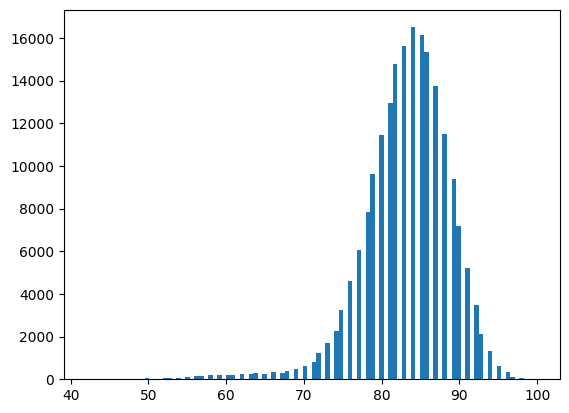

In [31]:
plt.hist(results_df_count["count"], bins=100)

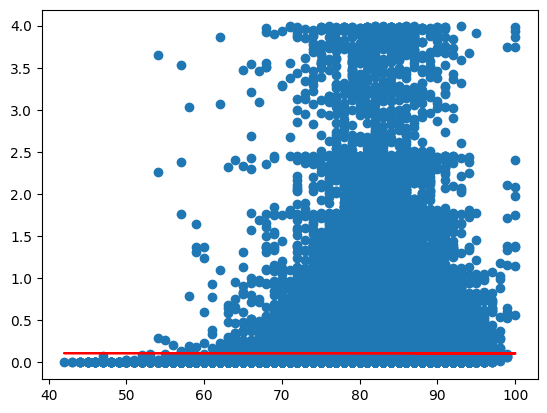

In [32]:
# Plot x as count and y as target

plt.scatter(results_df_count["count"], results_df_count["target"])

# Add regression line
import numpy as np
from sklearn.linear_model import LinearRegression

X = results_df_count["count"].values.reshape(-1, 1)
y = results_df_count["target"].values

reg = LinearRegression().fit(X, y)

plt.plot(X, reg.predict(X), color='red')
